# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [3]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

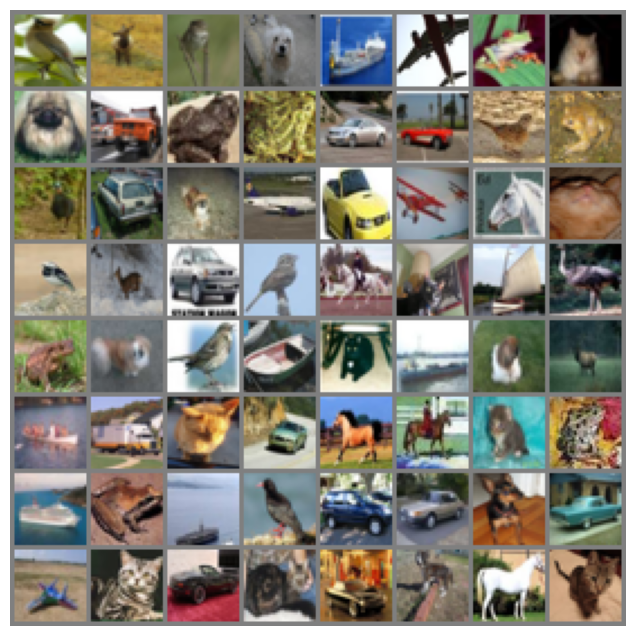

In [5]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [31]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 32, padding = 1,kernel_size = 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(64)
        self.batch2 = nn.BatchNorm2d(128)
        self.batch3 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(32, 64, padding = 1, stride = 1, kernel_size = 3)
        self.conv3 = nn.Conv2d(64, 128, padding = 1, stride = 1, kernel_size = 3)
        self.conv4 = nn.Conv2d(128, 256, padding = 1, stride = 1, kernel_size = 3)
        self.conv5 = nn.Conv2d(128, 128, padding = 1, stride = 1, kernel_size = 3)
        self.conv6 = nn.Conv2d(256, 256, padding = 1, stride = 1, kernel_size = 3)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc12 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.batch1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.batch2(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.batch3(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc12(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc12): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(i

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [33]:
# Test the forward pass with dummy data
output = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", output.size())
print(f"Output logits:\n{output.detach().cpu().numpy()}")
print(f"Output probabilities:\n{output.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.21349737 -0.0030204   0.02337882  0.09753    -0.02833109 -0.03769258
   0.1933531   0.0227285   0.18640462  0.17214245]
 [ 0.15001784  0.03035457  0.07871588 -0.00699429  0.05252963  0.05142079
  -0.01842094 -0.11275461 -0.06286353  0.22466403]]
Output probabilities:
[[0.11331587 0.09125534 0.09369648 0.10090827 0.08897459 0.08814554
  0.11105604 0.09363557 0.11028705 0.10872528]
 [0.11128461 0.09873383 0.10362607 0.09511425 0.10094772 0.10083584
  0.0940336  0.08556861 0.089946   0.11990948]]


In [34]:
batch_size = 64
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        output = model(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.43584375
             test accuracy: 0.5648
Step 1000    training accuracy: 0.6704415137614679
             test accuracy: 0.6474
Step 1500    training accuracy: 0.70671875
             test accuracy: 0.7165
Step 2000    training accuracy: 0.7744051032110092
             test accuracy: 0.7203
Step 2500    training accuracy: 0.8451704545454546
             test accuracy: 0.7272
Step 3000    training accuracy: 0.83778125
             test accuracy: 0.7486
Step 3500    training accuracy: 0.8933971774193549
             test accuracy: 0.768
Step 4000    training accuracy: 0.9378472222222223
             test accuracy: 0.7888
Step 4500    training accuracy: 0.928375
             test accuracy: 0.7704
Step 5000    training accuracy: 0.9680397727272727
             test accuracy: 0.7918
Step 5500    training accuracy: 0.9513221153846154
             test accuracy: 0.7915
Step 6000    training accuracy: 0.9810625
             test accuracy: 0.7919
Step 6500   

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

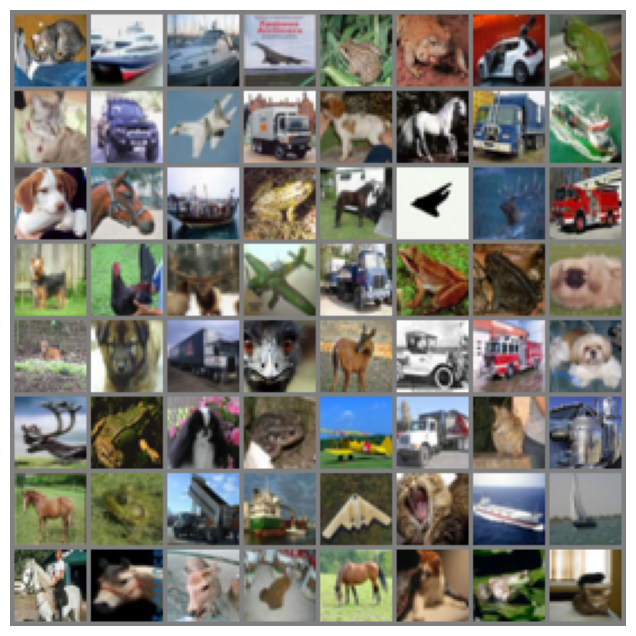

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane        ship     
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog           dog     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           c

In [36]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [44]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        #confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [45]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.814


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


NOTE
-----------------------
PLEASE READ
----------------------
The code above that I was given did not work, so I had to comment out the confusion matrix, thus the graphs below don't work.

C:\Users\dimit\AppData\Local\Temp\ipykernel_26684\3781514484.py:3: RuntimeWarning: invalid value encountered in true_divide
  return matrix / matrix.sum(axis=axis, keepdims=True)
C:\Users\dimit\anaconda3\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\dimit\anaconda3\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


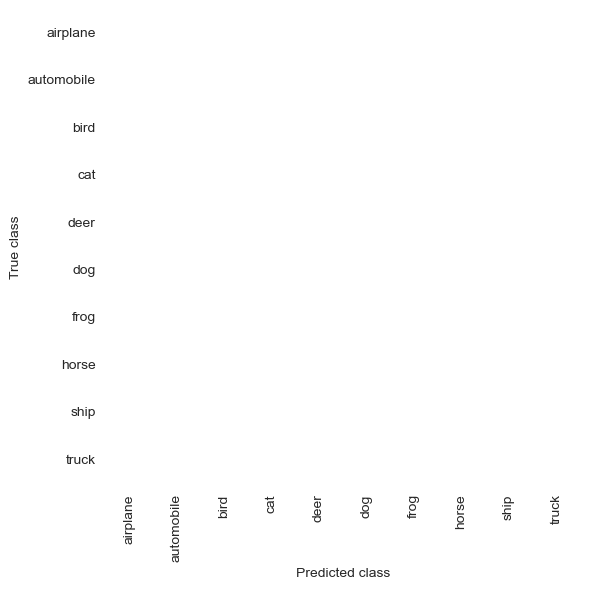

In [46]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

C:\Users\dimit\AppData\Local\Temp\ipykernel_26684\3781514484.py:3: RuntimeWarning: invalid value encountered in true_divide
  return matrix / matrix.sum(axis=axis, keepdims=True)


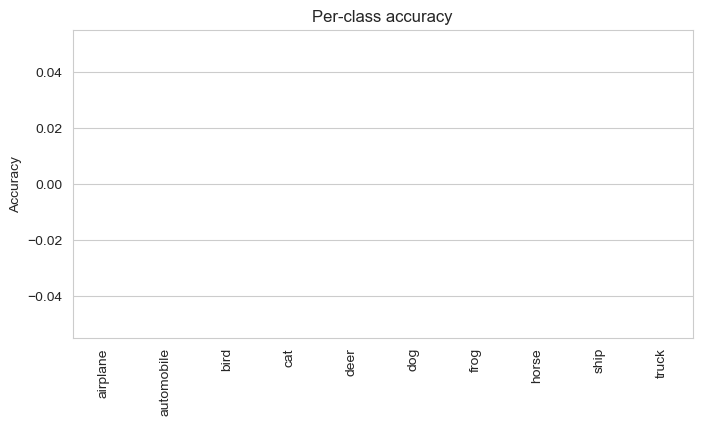

In [47]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?
**Answer:**
Adding more convolution layers was the biggest performance improver. I was surprised by how simple architectures can obtain a solid accuracy, definitely better than a guess.
3. Write down key lessons/insights you got during this exercise.

**Answer:**

I first experimented with a some random architectures, and stayed around 40-50% accuracy. Later, I implemented the architecture you see above. I used some knowledge about feature maps I gained from my "Greyscale image colorization" model to extract more features and reach a solid accuracy. Also, I've increased the training time to obtain better results.

I believe it is important to have good (and ENOUGH!) feature maps, as well as a solid dataset. When working on a colorization project, which was similar in one hand, the biggest issue were colors not represented in the training data, so it's number 1 for me to have a good dataset.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

We've used the same initialization procedure for rectified linear units as for sigmoid (and tanh) neurons. Our argument for that initialization was specific to the sigmoid function. Consider a network made entirely of rectified linear units (including outputs). 
1) Show that rescaling all the weights in the network by a constant factor c>0
 simply rescales the outputs by a factor  $c^{L-1}$
, where L
 is the number of layers. 
 
 2) How does this change if the final layer is a softmax?
 
 3) What do you think of using the sigmoid initialization procedure for the rectified linear units? Can you think of a better initialization procedure?

**Answer:**

1) Let's consider the output on the k-th layer. $y_k = max(0, z_k), z_k$ is a weighted sum of inputs and biases. If we rescale all the weights by c, then z_k just gets multiplied by c, and then we have $y_k = max(0,c * z_k)$. Now let's see how it propagates: $y_L = max(0, c * z_{L-1}, y_{L-1} = max(0,c * z_{L-1})$ and so on. We can take the c out of the max(), and then we definitely clearly see that $y_L$ just gets rescaled by $c^{L-1}$.

2) In this case, the "confidence" of the predictions will change, increasing if c > 1, and decreasing if c < 1.

3) First instinct here would be to replace it with sigmoid initialization, but that will just give us the "vanishing gradient problem". We can use our old friends, He and Glorot initializations to get better initializations, as they were designed to solve the vanishing gradient issue



